In [21]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt


In [22]:
n_qubits = 5
# 定义Cost Hamiltonian
cost_terms = [
    ("ZIIZI", 0.75),   # Z0 ⊗ Z3
    ("ZIIIZ", 0.75),   # Z0 ⊗ Z4
    ("IZIZI", 0.75),   # Z1 ⊗ Z3
    ("IIZIZ", 0.75),   # Z2 ⊗ Z4
    ("IIIZZ", 0.75),   # Z3 ⊗ Z4
    ("ZIIII", -0.5),   # -0.5*Z0
    ("IZIII", 0.25),   # 0.25*Z1
    ("IIZII", 0.25),   # 0.25*Z2
    ("IIIZI", -1.25),  # -1.25*Z3
    ("IIIIZ", -1.25),  # -1.25*Z4
]
cost_h= SparsePauliOp.from_list(cost_terms)

# 定义Driver Hamiltonian
driver_terms = [
    ("XIIII", 1.0),  # X0
    ("IXIII", 1.0),  # X1
    ("IIXII", 1.0),  # X2
    ("IIIXI", 1.0),  # X3
    ("IIIIX", 1.0),  # X4
]
driver_h= SparsePauliOp.from_list(driver_terms)


In [23]:
from qiskit.quantum_info import SparsePauliOp

# 定义5量子位的交换子哈密顿量
commutator_terms = [
    ("YIIZI", 6.0),   # Y0⊗Z3
    ("YIIIZ", 6.0),   # Y0⊗Z4
    ("YIIII", -6.0),  # Y0合并项
    ("IYIZI", 6.0),   # Y1⊗Z3
    ("ZIIYI", 6.0),   # Z0⊗Y3
    ("IZIYI", 6.0),   # Z1⊗Y3
    ("IIIYZ", 6.0),   # Y3⊗Z4
    ("IIIYI", -12.0), # Y3合并项
    ("ZIIIY", 6.0),   # Z0⊗Y4
    ("IIZIY", 6.0),   # Z2⊗Y4
    ("IIIZY", 6.0),   # Z3⊗Y4
    ("IIIIY", -12.0), # Y4合并项
]

comm_h = SparsePauliOp.from_list(commutator_terms)



第1步：能量 = 0.00032731 Ha | β_0 = +0.010000
第2步：能量 = -0.27213635 Ha | β_1 = -4.393108
第3步：能量 = -0.78518905 Ha | β_2 = -7.730575
第4步：能量 = -1.01803570 Ha | β_3 = -5.720881
第5步：能量 = -1.08654236 Ha | β_4 = -2.539275
第6步：能量 = -1.15772224 Ha | β_5 = -2.656519
第7步：能量 = -1.22472299 Ha | β_6 = -2.533869
第8步：能量 = -1.29198433 Ha | β_7 = -2.508114
第9步：能量 = -1.36015554 Ha | β_8 = -2.481478
第10步：能量 = -1.42954049 Ha | β_9 = -2.452895
第11步：能量 = -1.49966224 Ha | β_10 = -2.407543
第12步：能量 = -1.56964902 Ha | β_11 = -2.339724
第13步：能量 = -1.63853802 Ha | β_12 = -2.249721
第14步：能量 = -1.70557530 Ha | β_13 = -2.143905
第15步：能量 = -1.77037026 Ha | β_14 = -2.031845
第16步：能量 = -1.83288000 Ha | β_15 = -1.922704
第17步：能量 = -1.89328828 Ha | β_16 = -1.822753
第18步：能量 = -1.95187134 Ha | β_17 = -1.734908
第19步：能量 = -2.00890290 Ha | β_18 = -1.659575
第20步：能量 = -2.06460461 Ha | β_19 = -1.595762
第21步：能量 = -2.11912872 Ha | β_20 = -1.541898
第22步：能量 = -2.17255880 Ha | β_21 = -1.496314
第23步：能量 = -2.22491948 Ha | β_22 = -1.457488
第24步：能量 

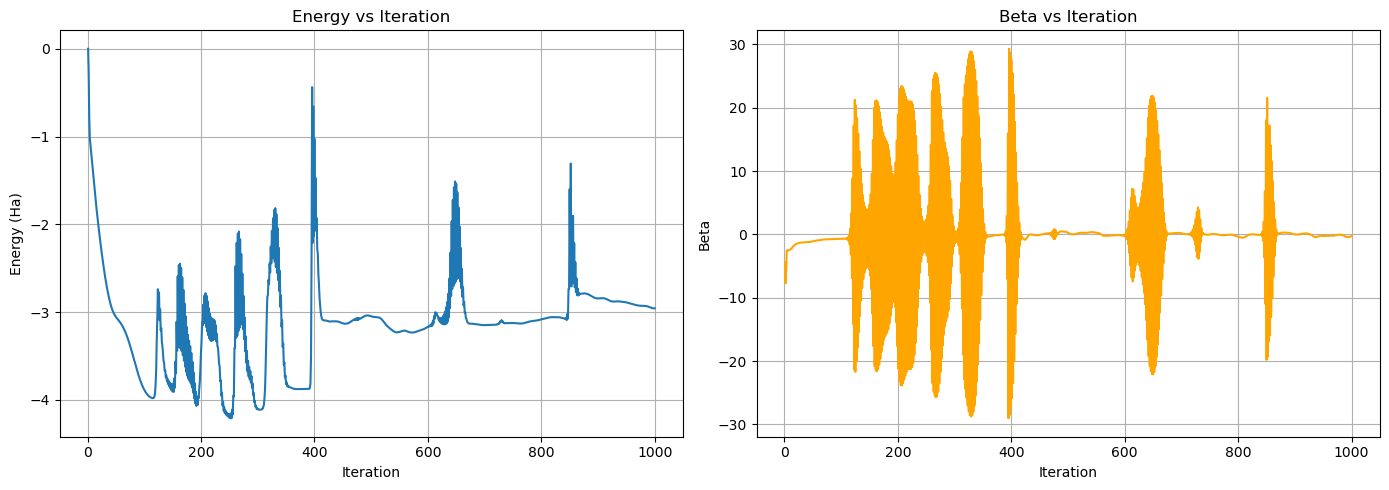

In [24]:

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))



def main_loop(qc,cost_h,driver_h,comm_h,delta_t,beta_0,n_steps):
    beta =[beta_0]
    energies=[]
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer,cost_h,driver_h,beta[i],delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta =-1*state.expectation_value(comm_h).real
        beta.append(next_beta)
        print(f"第{i + 1}步：能量 = {energy:.8f} Ha | β_{i} = {beta[i]:+.6f}")
        
    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=5):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.01
delta_t = 0.03
s_beta, s_energies, final_circuit = main_loop(
    qc=qc_initial,
    cost_h=cost_h,
    driver_h=driver_h,
    comm_h=comm_h,
    delta_t=delta_t,
    beta_0=beta_0,
    n_steps=n_steps
)

# 生成迭代步列表
iterations = list(range(1, len(s_energies) + 1))

# 创建两个子图
plt.figure(figsize=(14, 5))

# 第一个子图：Energy vs Iteration
plt.subplot(1, 2, 1)
plt.plot(iterations, s_energies)
plt.title('Energy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.grid(True)

# 第二个子图：Beta vs Iteration
plt.subplot(1, 2, 2)
plt.plot(iterations, s_beta[1:], color='orange')
plt.title('Beta vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Beta')
plt.grid(True)

plt.tight_layout()
plt.show()
